# Getting started

We will start by setting up our environment: a Numba and a supported GPU.

In [4]:
!pip install --upgrade numba

# Environment Check

First, ensure that Numba can interact with CUDA on your system:

In [5]:
import numpy as np

import numba
from numba import cuda

print(np.__version__)
print(numba.__version__)

2.2.4
0.61.2


In [6]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4070 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-252888de-d6d3-3e6a-315b-393d94798214
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported


True

# Writing Your First CUDA Kernel

Let's start by creating a simple kernel to perform grayscale conversion on an image.

Import Libraries

In [7]:
import numpy as np
import numba.cuda as cuda
from skimage import io
import matplotlib.pyplot as plt

# Load an Image

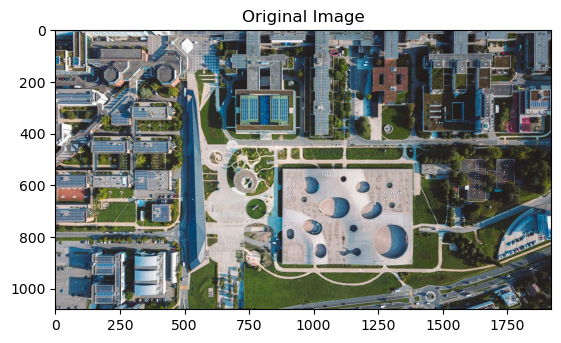

In [8]:
image = io.imread('EPFL_aereal.jpeg')
plt.imshow(image)
plt.title('Original Image')
plt.show()

Grayscale Conversion Kernel This kernel converts an RGB image to grayscale by applying the luminosity method.

In [9]:
@cuda.jit
def rgb2gray_kernel(d_result, d_image):
    x, y = cuda.grid(2)
    if x < d_image.shape[0] and y < d_image.shape[1]:
        r, g, b = d_image[x, y]
        # Luminosity method: 0.21 R + 0.72 G + 0.07 B
        gray = 0.21 * r + 0.72 * g + 0.07 * b
        d_result[x, y] = gray

# Memory Management

Transfer data to the GPU.

In [10]:
d_image = cuda.to_device(image)
d_result = cuda.device_array(image.shape[:2], dtype=np.uint8)

# Kernel Invocation

Define the size of blocks and grid.

In [11]:
threadsperblock = (16, 16)
blockspergrid_x = int(np.ceil(image.shape[0] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(image.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

rgb2gray_kernel[blockspergrid, threadsperblock](d_result, d_image)

# Retrieve Data from GPU

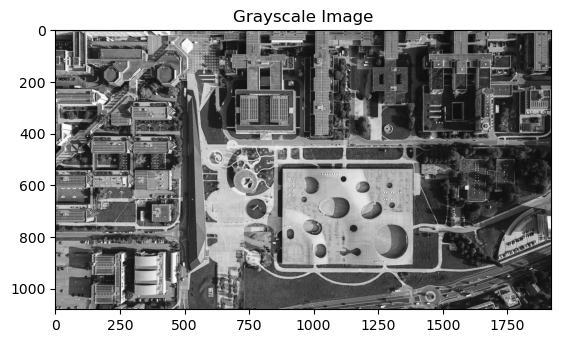

In [12]:
grayscale_image = d_result.copy_to_host()
plt.imshow(grayscale_image, cmap='gray')
plt.title('Grayscale Image')
plt.show()

# Measuring Performance

First, import the time module for CPU timing:

In [13]:
import time

# CPU Grayscale Conversion

Let’s implement a CPU version of the grayscale conversion to compare performance:

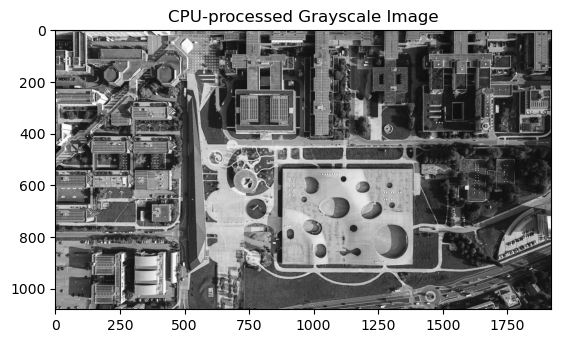

CPU Time: 5.08419 seconds


In [14]:
def rgb2gray_cpu(result, image):    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r, g, b = image[i, j]
            result[i, j] = int(0.21 * r + 0.72 * g + 0.07 * b)
    return result

# Measure CPU time
grayscale = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

start_time = time.perf_counter()
cpu_gray = rgb2gray_cpu(grayscale, image)
cpu_time = time.perf_counter() - start_time

plt.imshow(cpu_gray, cmap='gray')
plt.title('CPU-processed Grayscale Image')
plt.show()

print(f"CPU Time: {cpu_time:.5f} seconds")

In [15]:
def rgb2gray_cpu_numpy(result, image):    
    result[...] = (0.21 * image[..., 0] + 0.72 * image[..., 1] + 0.07 * image[..., 2]).astype(int)
    return result

# Measure CPU Numpy time
grayscale = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
start_time = time.perf_counter()
cpu_np_gray = rgb2gray_cpu_numpy(grayscale, image)
cpu_np_time = time.perf_counter() - start_time

print(f"CPU Time (Numpy): {cpu_np_time:.5f} seconds")

CPU Time (Numpy): 0.01262 seconds


In [16]:
from numba import njit 
@njit
def rgb2gray_numba(result, image):    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r, g, b = image[i, j]
            result[i, j] = int(0.21 * r + 0.72 * g + 0.07 * b)
    return result

# Measure CPU Numba time
grayscale = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

cpu_gray = rgb2gray_numba(grayscale, image)
start_time = time.perf_counter()
cpu_gray = rgb2gray_numba(grayscale, image)
cpu_numba_time = time.perf_counter() - start_time

print(f"CPU Time: {cpu_numba_time:.5f} seconds")

CPU Time: 0.00188 seconds


# GPU Performance Measurement

For GPU performance, we use Numba's CUDA event system to measure kernel execution time:

In [17]:
start_event = cuda.event()
end_event = cuda.event()

start_event.record()
rgb2gray_kernel[blockspergrid, threadsperblock](d_result, d_image)
end_event.record()
end_event.synchronize()  # Wait for the event to be executed!

gpu_time = cuda.event_elapsed_time(start_event, end_event) / 1000.0  # Convert milliseconds to seconds
print(f"GPU Time: {gpu_time:.5f} seconds")

GPU Time: 0.00028 seconds


Comparison Finally, let's compare the times:

In [18]:
print(f"Speedup: {cpu_time / gpu_time:.2f}x")
print(f"Speedup: {cpu_numba_time / gpu_time:.2f}x")

Speedup: 18448.77x
Speedup: 6.83x
